## Macro work and EDA


In [160]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import feature_engine
from feature_engine.timeseries.forecasting import LagFeatures
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

#from sklearn.preprocessing import MinMaxScaler, StandardScaler # could just use the simple library


# fix indexes after cleaning

In [91]:
#Goal
#predict monthly interval moves
#predict daily interval moves

#Steps:
#1. Process, clean data, EDA
#2. Correlation, PCA analysis vs Stock indices
#3. Prep data for DDQN input
#4. Create Macro DDQN agent, potentialy, if in 1m and 1d the move will be up or down, overvalued, undervalued


In [92]:
def import_files(file_path = r"C:\Users\augus\OneDrive\Desktop\Stockholm University\Nomades\Python\MADDQG Team - DQN Variants\macro_input", columns_to_drop = ['DGS10_CHG', 'DGS10_CCA', 'DGS10_CCH'] ):
    #import macro files
    macro_data = {}  # dictionary to store DataFrames

    for period in ["daily_without_VIX_5_20_1987", "daily_with_VIX_1_2_1990", "monthly_final"]: # "other"
        file_name = f'combined_file_{period}.csv'
        full_file = os.path.join(file_path, file_name)
        macro_data[period] = pd.read_csv(full_file, na_values='.')


    daily_macro_data_w_vix = macro_data['daily_with_VIX_1_2_1990']
    daily_macro_data_no_vix = macro_data['daily_without_VIX_5_20_1987']
    monthly_macro_data = macro_data['monthly_final']
    # other_macro_data = macro_data['other']

    # specified columns to drop are in method inputs
    daily_macro_data_w_vix.drop(columns=columns_to_drop, inplace=True)
    daily_macro_data_no_vix.drop(columns=columns_to_drop, inplace=True)

    return daily_macro_data_w_vix, daily_macro_data_no_vix, monthly_macro_data



In [93]:
file_path = r"C:\Users\augus\OneDrive\Desktop\Stockholm University\Nomades\Python\MADDQG Team - DQN Variants\macro_input"
columns_to_drop = ['DGS10_CHG', 'DGS10_CCA', 'DGS10_CCH']
daily_macro_data_w_vix, daily_macro_data_no_vix, monthly_macro_data = import_files(file_path, columns_to_drop)

In [153]:
import pandas as pd
import numpy as np

def split_and_clean_data(df, data_split, for_nan_remove_rows_or_impute_with_mean="remove_rows"):
    print("Original DataFrame size:", df.shape)  # diagnostics: check original DataFrame size
    print("\n Basic statistics:\n ")
    print(df.info())
    
    # ensure the DATE column is a datetime type and format it to day-month-year
    df['DATE'] = pd.to_datetime(df['DATE']).dt.strftime('%d-%m-%Y')
    df['DATE'] = pd.to_datetime(df['DATE'], format='%d-%m-%Y')  # reconvert to datetime without time
    
    if for_nan_remove_rows_or_impute_with_mean == "remove_rows":
        df = df.dropna()  # ensure DataFrame is updated after dropping NaN
        print("\n DataFrame size after dropping rows:", df.shape)  # Diagnostics
    elif for_nan_remove_rows_or_impute_with_mean == "impute_with_mean":
        means = df.select_dtypes(include=[np.number]).mean()
        df = df.fillna(means)  
        print("\n DataFrame size after imputing mean:", df.shape)  # Diagnostics
    else:
        raise ValueError("\n Not clear instructions what to do with missing values")

    df = df.reset_index(drop=True)  # Reset index after modifying rows
    df_no_date = df.drop(columns=["DATE"], errors='ignore')
    data_index = int(len(df) * (data_split / 100))

    macro_train_w_date = df.iloc[:data_index]
    macro_test_w_date = df.iloc[data_index:]
    macro_train_no_date = df_no_date.iloc[:data_index]
    macro_test_no_date = df_no_date.iloc[data_index:]

    # Check for NaNs, infinities, or zeroes
    has_infinities_or_nans = df.isnull().values.any() or np.isinf(df.select_dtypes(include=[np.number])).values.any()
    print("\n Contains infinite or NaN values:", has_infinities_or_nans)

    print("\n Unique values per column:")
    print(df.nunique())

    print("\n Descriptive statistics:")
    print(df.describe())

    has_zeros = (df.select_dtypes(include=[np.number]) == 0).any().any()
    print("\n Contains zero values:", has_zeros)

    return (df, macro_train_w_date, macro_test_w_date, df_no_date, macro_train_no_date, macro_test_no_date, data_index)


def standardize_data(df, data_split):
    df_copy = df.copy()  
    
    if "DATE" in df_copy.columns:
        df_copy.drop(columns=['DATE'], inplace=True)
    
    data_index = int(len(df_copy) * (data_split / 100))
    train_means = df_copy.iloc[:data_index].mean()
    train_std_devs = df_copy.iloc[:data_index].std()
    
    df_standardized = (df_copy - train_means) / train_std_devs
    df_standardized = df_standardized.reset_index(drop=True)

    df_standardized_train = df_standardized.iloc[:data_index]
    df_standardized_test = df_standardized.iloc[data_index:]

    # Optionally, we can add back the dates here if needed
    # df_standardized['DATE'] = df['DATE']
    
    # check for NaNs, infinities, or zeroes
    has_infinities_or_nans = df_standardized.isnull().values.any() or np.isinf(df_standardized.select_dtypes(include=[np.number])).values.any()
    print("\n Contains infinite or NaN values:", has_infinities_or_nans)

    print(" \nUnique values per column:")
    print(df_standardized.nunique())

    print("\n Descriptive statistics:")
    print(df_standardized.describe())

    has_zeros = (df_standardized.select_dtypes(include=[np.number]) == 0).any().any()
    print("\n Contains zero values:", has_zeros)

    return df_standardized, df_standardized_train, df_standardized_test
    


In [154]:
(df, macro_train_w_date, macro_test_w_date, df_no_date, macro_train_no_date,
  macro_test_no_date, data_index)    = split_and_clean_data(monthly_macro_data, 80, 
                                                         for_nan_remove_rows_or_impute_with_mean="impute_with_mean")

Original DataFrame size: (554, 46)

 Basic statistics:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   DATE                         554 non-null    datetime64[ns]
 1   PPIACO                       554 non-null    float64       
 2   HOUST                        554 non-null    int64         
 3   PCE                          553 non-null    float64       
 4   UMCSENT                      553 non-null    float64       
 5   PCE.1                        553 non-null    float64       
 6   PSAVERT                      553 non-null    float64       
 7   CPALTT01USM657N              554 non-null    float64       
 8   FEDFUNDS                     554 non-null    float64       
 9   PPIACO_NBD20200101           554 non-null    float64       
 10  HOUST_NBD20200101            554 non-null    float64 

In [96]:
df_standardized, df_standardized_train, df_standardized_test = standardize_data(macro_train_no_date, 80)

Contains infinite or NaN values: False
Unique values per column:
PPIACO                         249
HOUST                          268
PCE                            306
UMCSENT                        219
PCE.1                          306
PSAVERT                        102
CPALTT01USM657N                305
FEDFUNDS                       243
PPIACO_NBD20200101             249
HOUST_NBD20200101              268
PCE_NBD20200101                306
UMCSENT_NBD20200101            219
PCE_NBD20200101.1              306
PSAVERT_NBD20200101            102
CPALTT01USM657N_NBD20200101    305
FEDFUNDS_NBD20200101           243
PPIACO_CHG                      58
HOUST_CHG                      209
PCE_CHG                        244
UMCSENT_CHG                    122
PCE_CHG.1                      244
PSAVERT_CHG                     38
CPALTT01USM657N_CHG            306
FEDFUNDS_CHG                   110
PPIACO_CCA                     293
HOUST_CCA                      304
PCE_CCA                  

In [97]:
dataframes = {
    "df": df,
    "macro_train_w_date": macro_train_w_date,
    "macro_test_w_date": macro_test_w_date,
    "df_no_date": df_no_date,
    "macro_train_no_date": macro_train_no_date,
    "macro_test_no_date": macro_test_no_date,
    "df_standardized": df_standardized,
    "df_standardized_train": df_standardized_train,
    "df_standardized_test": df_standardized_test
}

# Loop through dictionary and save each DataFrame to CSV
for name, data in dataframes.items():
    if isinstance(data, pd.DataFrame):
        data.to_csv(f"{name}.csv")
    elif isinstance(data, np.ndarray):
        pd.DataFrame(data).to_csv(f"{name}.csv")
    else:
        print(f"warning: {name} is not a dataframe or ndarra and was not saved")


## Density Distribution

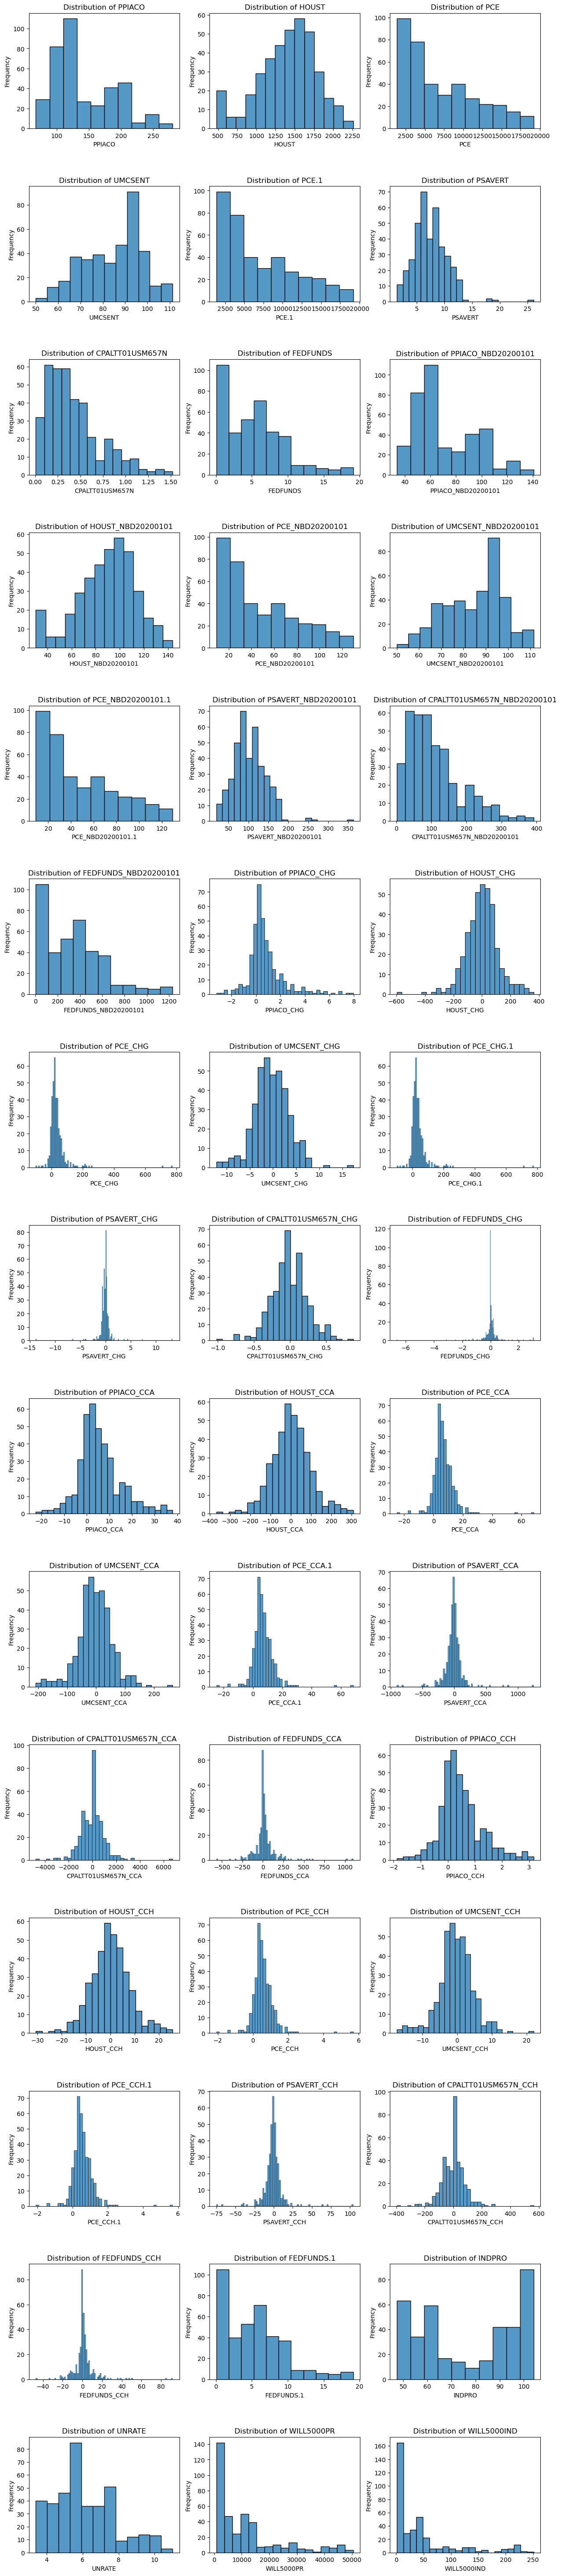

In [98]:


def plot_distplot_for_each_column(df):
    # Exclude 'DATE' column if present
    columns_to_plot = df.columns.drop('DATE') if 'DATE' in df.columns else df.columns
    
    num_cols = len(columns_to_plot)
    num_rows = math.ceil(num_cols / 3)  # Calculate the number of rows required

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    fig.subplots_adjust(hspace=0.5)

    for i, column in enumerate(columns_to_plot):
        row_num = i // 3
        col_num = i % 3
        ax = axes[row_num, col_num] if num_rows > 1 else axes[col_num]
        sns.histplot(df[column].dropna(), kde=False, ax=ax)  # Plot distribution plot for each column
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    # Hide any empty subplots
    for i in range(num_cols, num_rows * 3):
        row_num = i // 3
        col_num = i % 3
        axes[row_num, col_num].axis('off')

    plt.show()

# Call the function with your DataFrame
plot_distplot_for_each_column(df)

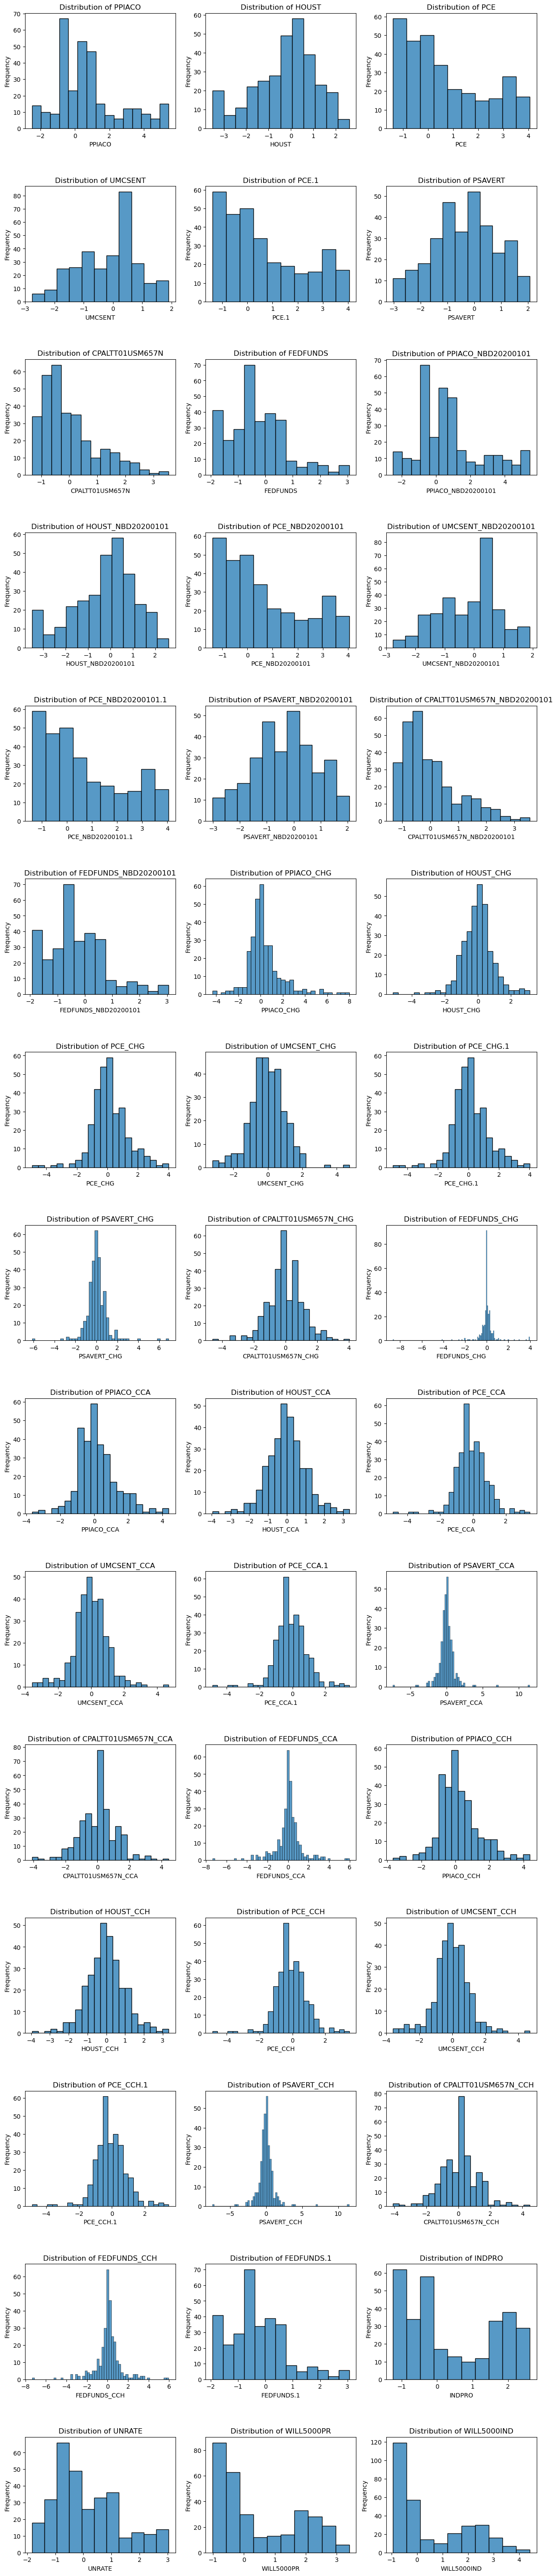

In [99]:
plot_distplot_for_each_column(df_standardized)

In [100]:
# def plot_distplot_for_each_column(df):
#     # Exclude 'DATE' column if present
#     columns_to_plot = df.columns.drop('DATE') if 'DATE' in df.columns else df.columns
    
#     for column in columns_to_plot:
#         plt.figure(figsize=(10, 5))
#         sns.displot(df[column].dropna(), kde=False)  # Plot distribution plot for each column
#         plt.title(f'Distribution of {column}')
#         plt.xlabel(column)
#         plt.ylabel('Frequency')
#         plt.show()

# # Call the function with your DataFrame
# plot_distplot_for_each_column(df)

## Univariate analysis

In [101]:
#???

        

## Bivariate analysis

In [102]:
def plot_graph_with_trendline(df, y_values:str ='INDPRO'):
    # Exclude 'DATE' column if present
    columns_to_plot = df.columns.drop('DATE') if 'DATE' in df.columns else df.columns
    
    num_cols = len(columns_to_plot)
    num_rows = math.ceil(num_cols / 3)  # Calculate the number of rows required

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))
    fig.subplots_adjust(hspace=0.5)

    for i, column in enumerate(columns_to_plot):
        row_num = i // 3
        col_num = i % 3
        ax = axes[row_num, col_num] if num_rows > 1 else axes[col_num]
        
        x = df[column]
        y = df[y_values]
        ax.scatter(x, y, alpha = 0.1, s = 5, c = "black", edgecolors = "none")
        ax.set_title(f'Scatter plot with trendline for {column}')
        ax.set_xlabel(column)
        ax.set_ylabel(y_values)
        ax.tick_params(axis='x', rotation=45)
        
        sns.regplot(x=x, y=y, scatter=False, ax=ax)

    # Hide any empty subplots
    for i in range(num_cols, num_rows * 3):
        row_num = i // 3
        col_num = i % 3
        axes[row_num, col_num].axis('off')

    plt.show()

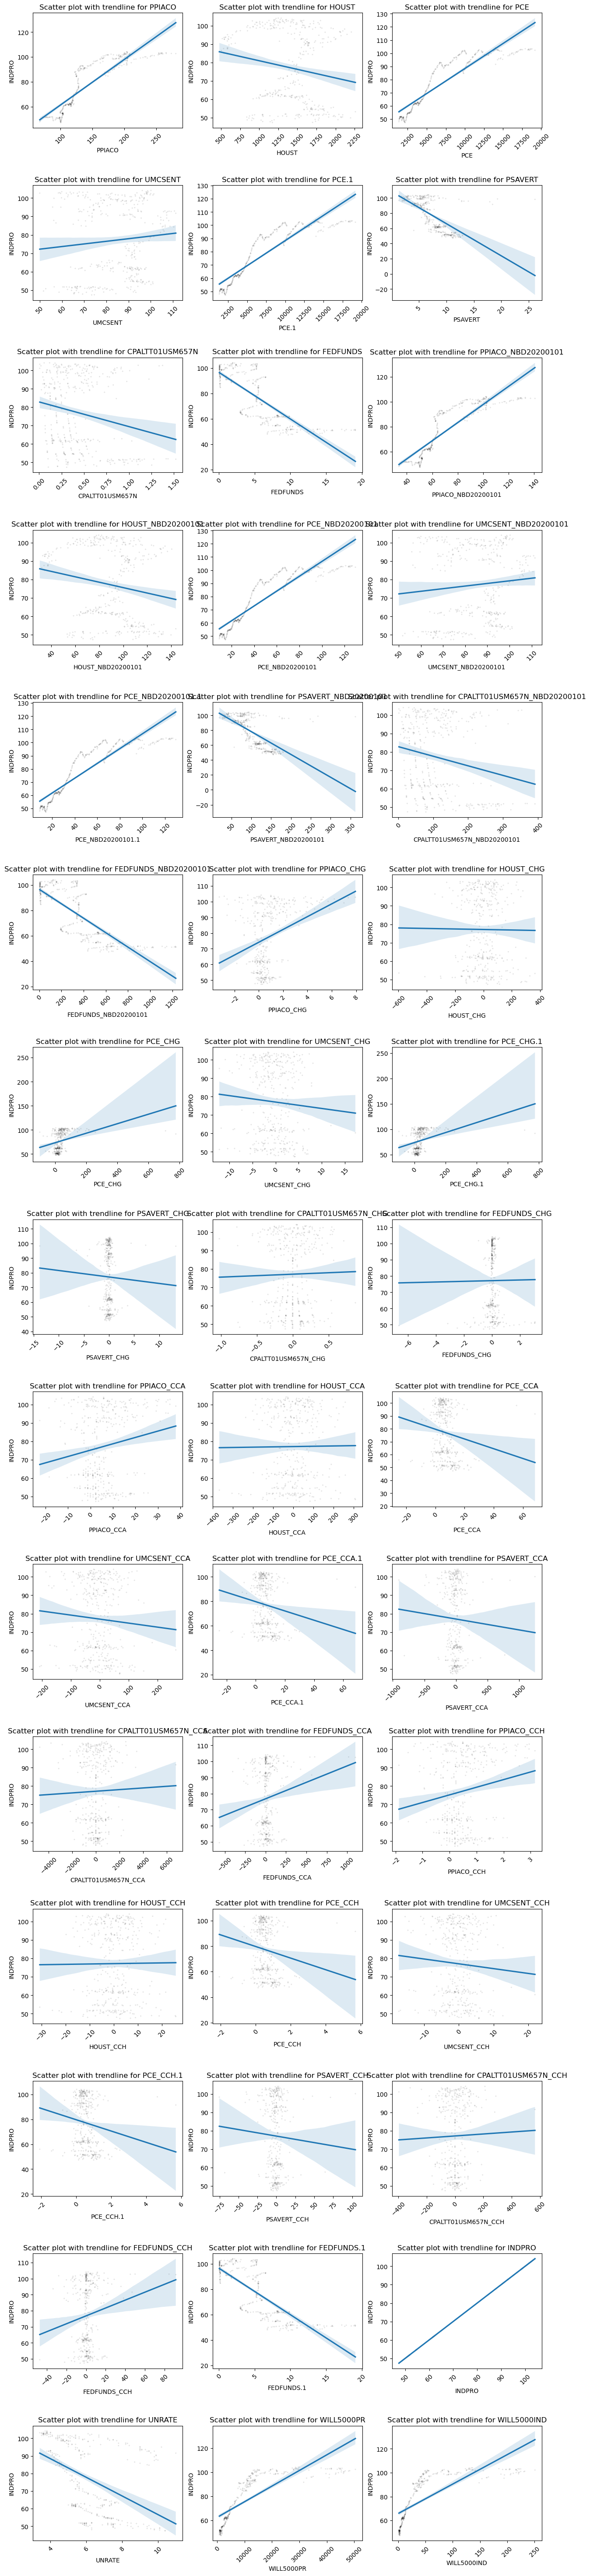

In [103]:
plot_graph_with_trendline(df, y_values='INDPRO')

## Correlation matrix and Heatmap

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr_matrix2(df):
    # Drop non-numeric columns and 'DATE' column if present
    df_numeric = df.select_dtypes(include='number').drop(columns='DATE', errors='ignore')
    
    # Calculate correlation matrix directly from the DataFrame
    correlation_matrix = df.corr()
    
    fig, ax = plt.subplots(figsize=(50, 50))
    # Plot heatmap of the correlation matrix
    sns.heatmap(correlation_matrix, annot=True)
    plt.show()

In [105]:
def plot_corr_matrix(df):
    # Drop non-numeric columns and 'DATE' column if present
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns='DATE', errors='ignore')  # Explicitly include np.number for clarity
    
    # Ensure there are enough columns to calculate correlations
    if df_numeric.shape[1] < 2:
        print("Not enough numeric columns to calculate correlations.")
        return
    
    # Calculate correlation matrix directly from the DataFrame
    correlation_matrix = df_numeric.corr()
    
    # Check if the correlation matrix is too small or NaN (can happen with no variance in data)
    if correlation_matrix.size < 1 or correlation_matrix.isnull().all().all():
        print("Failed to generate a valid correlation matrix.")
        return
    
    # Initialize the figure and plot
    fig, ax = plt.subplots(figsize=(50, 50))
    # Plot heatmap of the correlation matrix with proper settings to ensure all labels and annotations are visible
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", square=True, cbar=True, cmap='coolwarm', ax=ax)
    plt.title('Correlation Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

def print_corr_matrix(df):
    # Drop non-numeric columns and 'DATE' column if present
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns='DATE', errors='ignore')
    
    # Ensure there are enough columns to calculate correlations
    if df_numeric.shape[1] < 2:
        print("Not enough numeric columns to calculate correlations.")
        return
    
    # Calculate correlation matrix directly from the DataFrame
    correlation_matrix = df_numeric.corr()
    
    # Check if the correlation matrix is too small or NaN (can happen with no variance in data)
    if correlation_matrix.size < 1 or correlation_matrix.isnull().all().all():
        print("Failed to generate a valid correlation matrix.")
        return
    
    # Print the correlation matrix
    print(correlation_matrix)


In [106]:
print_corr_matrix(macro_test_no_date)

                               PPIACO     HOUST       PCE   UMCSENT     PCE.1  \
PPIACO                       1.000000  0.609452  0.877027 -0.844913  0.877027   
HOUST                        0.609452  1.000000  0.776669 -0.522673  0.776669   
PCE                          0.877027  0.776669  1.000000 -0.699377  1.000000   
UMCSENT                     -0.844913 -0.522673 -0.699377  1.000000 -0.699377   
PCE.1                        0.877027  0.776669  1.000000 -0.699377  1.000000   
PSAVERT                     -0.284449  0.239551 -0.049384  0.081981 -0.049384   
CPALTT01USM657N              0.506971  0.468374  0.407118 -0.481451  0.407118   
FEDFUNDS                     0.463730  0.078588  0.602340 -0.199643  0.602340   
PPIACO_NBD20200101           1.000000  0.609452  0.877027 -0.844913  0.877027   
HOUST_NBD20200101            0.609452  1.000000  0.776669 -0.522673  0.776669   
PCE_NBD20200101              0.877027  0.776669  1.000000 -0.699377  1.000000   
UMCSENT_NBD20200101         

In [107]:
ohlcv_data = df_standardized_train
finite_check = np.isfinite(ohlcv_data)
non_finite = ~finite_check
has_infinities_or_nans = non_finite.any().any()  # Returns True if any value in the DataFrame is False in finite_check

print("Contains infinite or NaN values:", has_infinities_or_nans)

print("Unique values per column:")
print(ohlcv_data.nunique())

print("Descriptive statistics:")
print(ohlcv_data.describe())

zero_values = (ohlcv_data == 0)
zero_values
# Check if there are any zero values in the DataFrame
has_zeros = zero_values.any().any()
print("Contains zero values:", has_zeros)

Contains infinite or NaN values: False
Unique values per column:
PPIACO                         194
HOUST                          214
PCE                            244
UMCSENT                        181
PCE.1                          244
PSAVERT                         82
CPALTT01USM657N                243
FEDFUNDS                       206
PPIACO_NBD20200101             194
HOUST_NBD20200101              214
PCE_NBD20200101                244
UMCSENT_NBD20200101            181
PCE_NBD20200101.1              244
PSAVERT_NBD20200101             82
CPALTT01USM657N_NBD20200101    243
FEDFUNDS_NBD20200101           206
PPIACO_CHG                      38
HOUST_CHG                      174
PCE_CHG                        199
UMCSENT_CHG                    110
PCE_CHG.1                      199
PSAVERT_CHG                     34
CPALTT01USM657N_CHG            244
FEDFUNDS_CHG                   106
PPIACO_CCA                     233
HOUST_CCA                      243
PCE_CCA                  

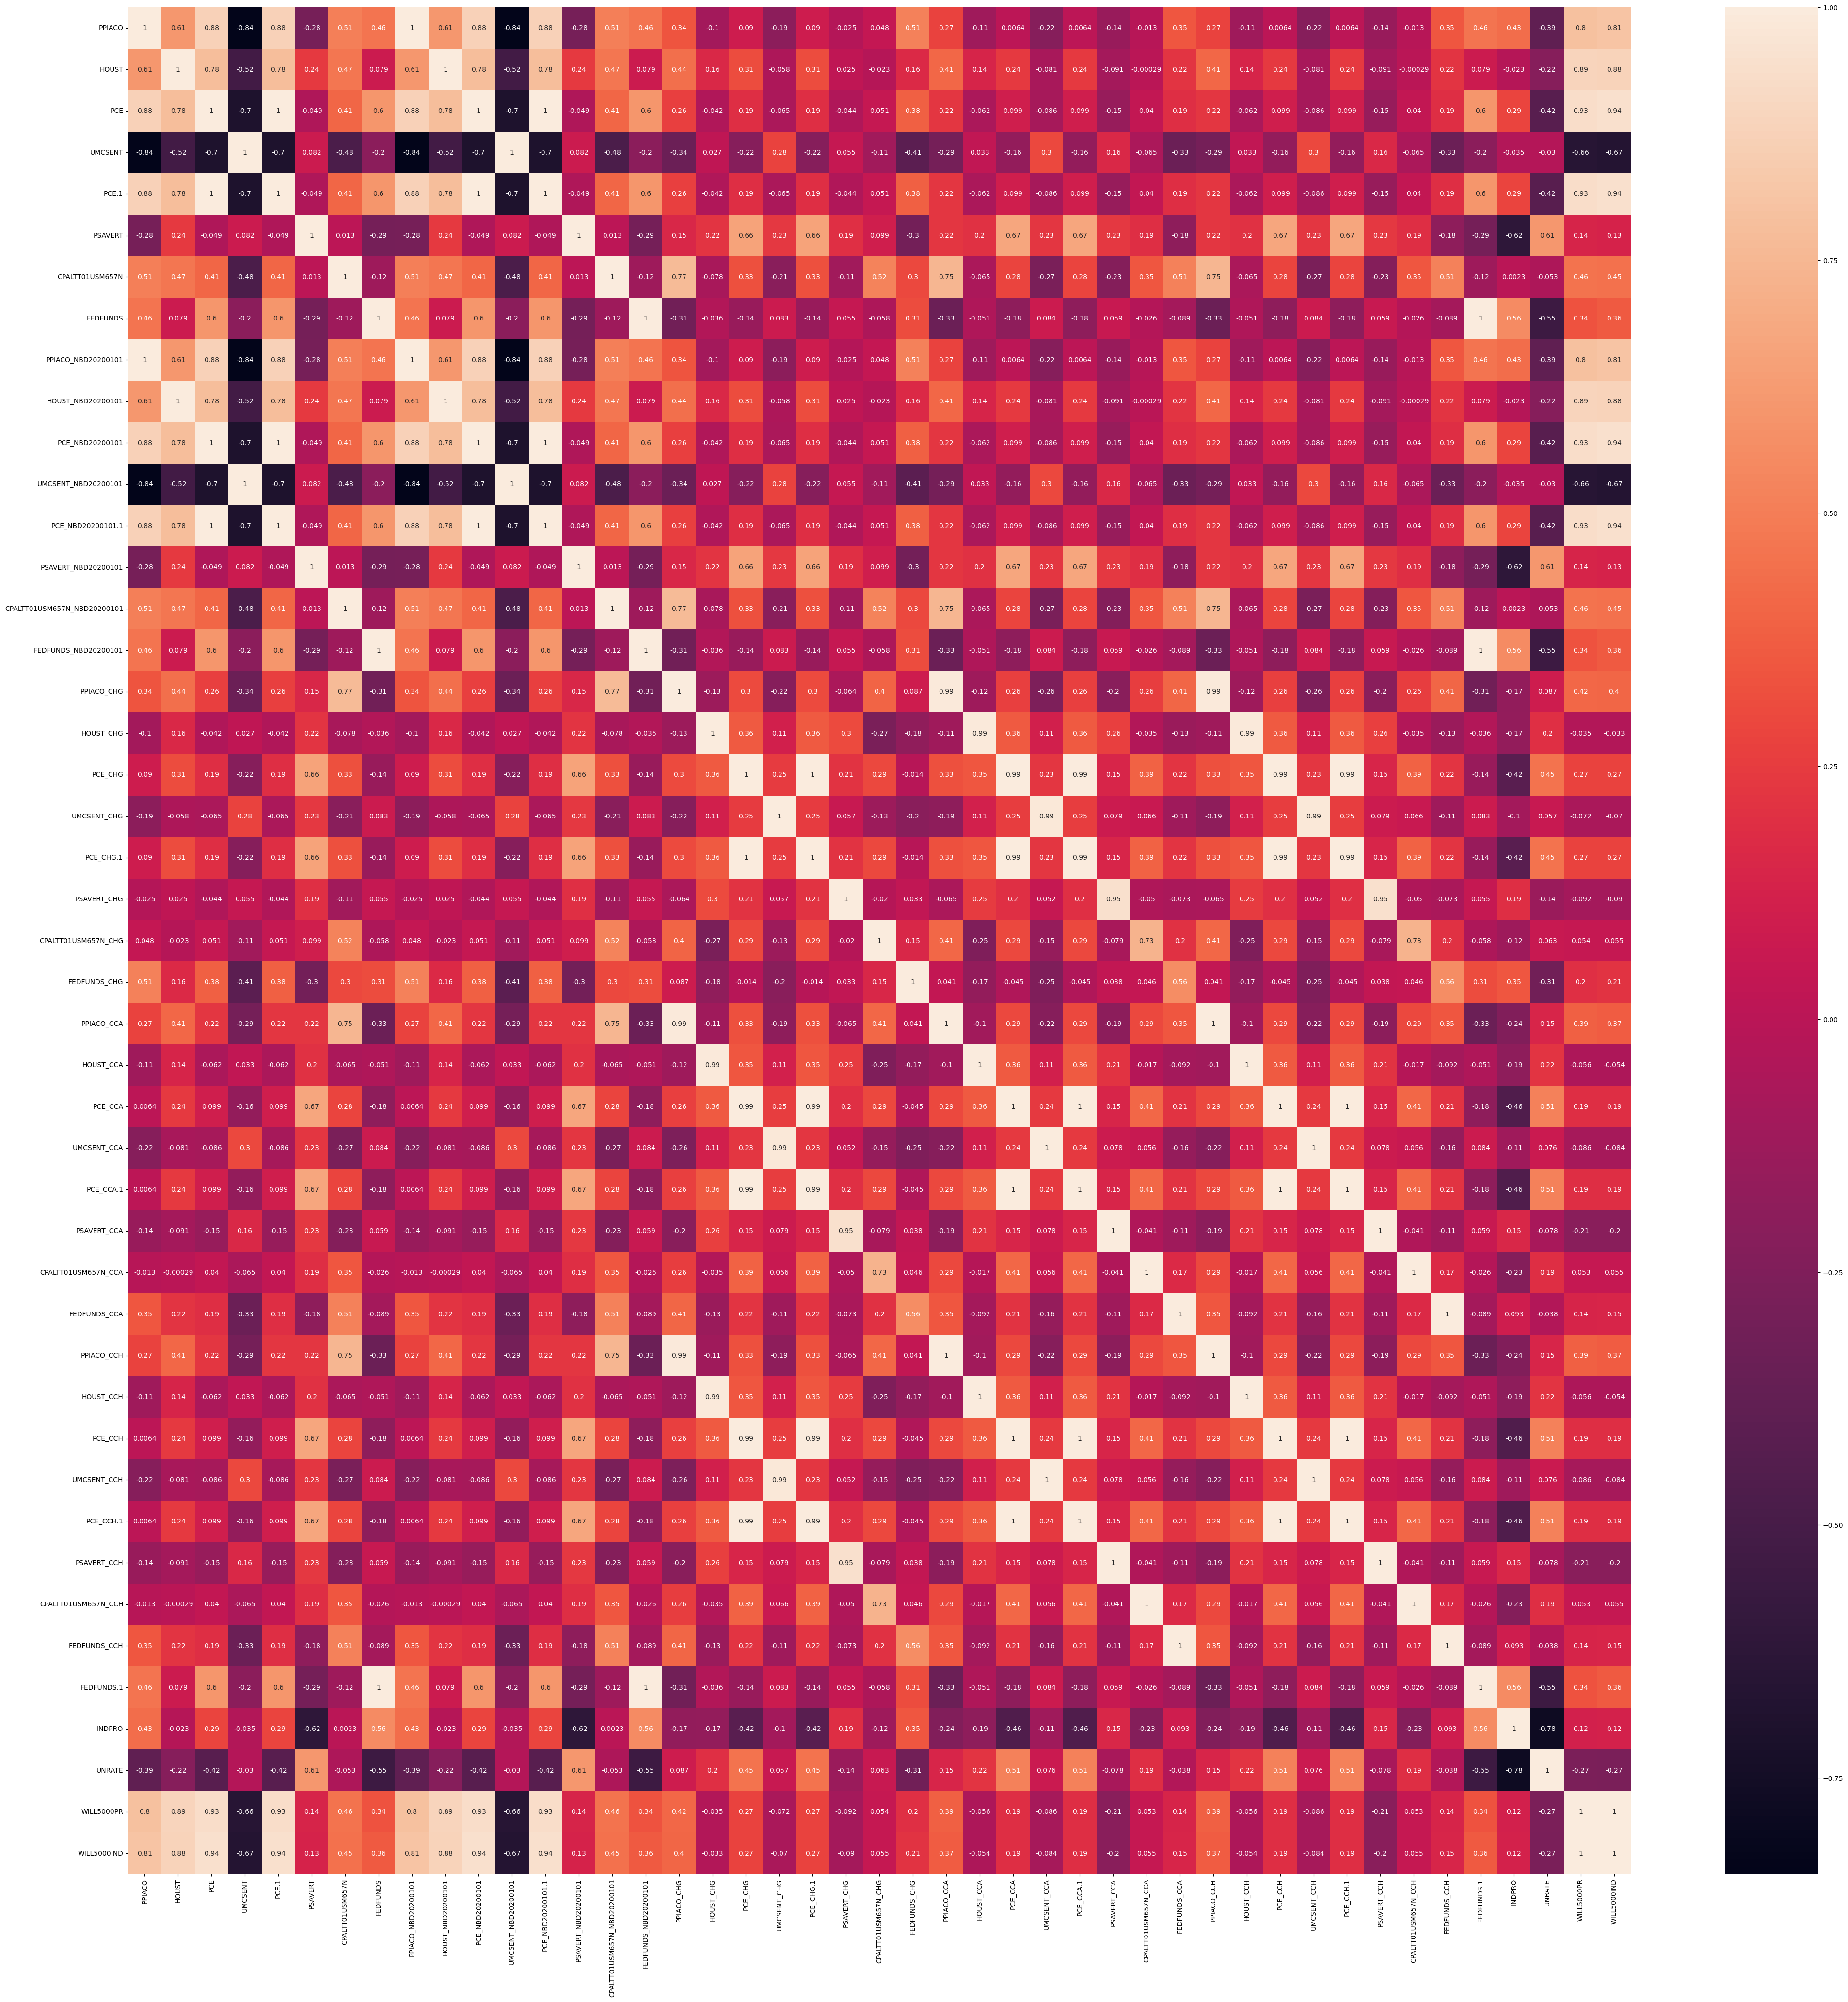

In [108]:
plot_corr_matrix2(macro_test_no_date)

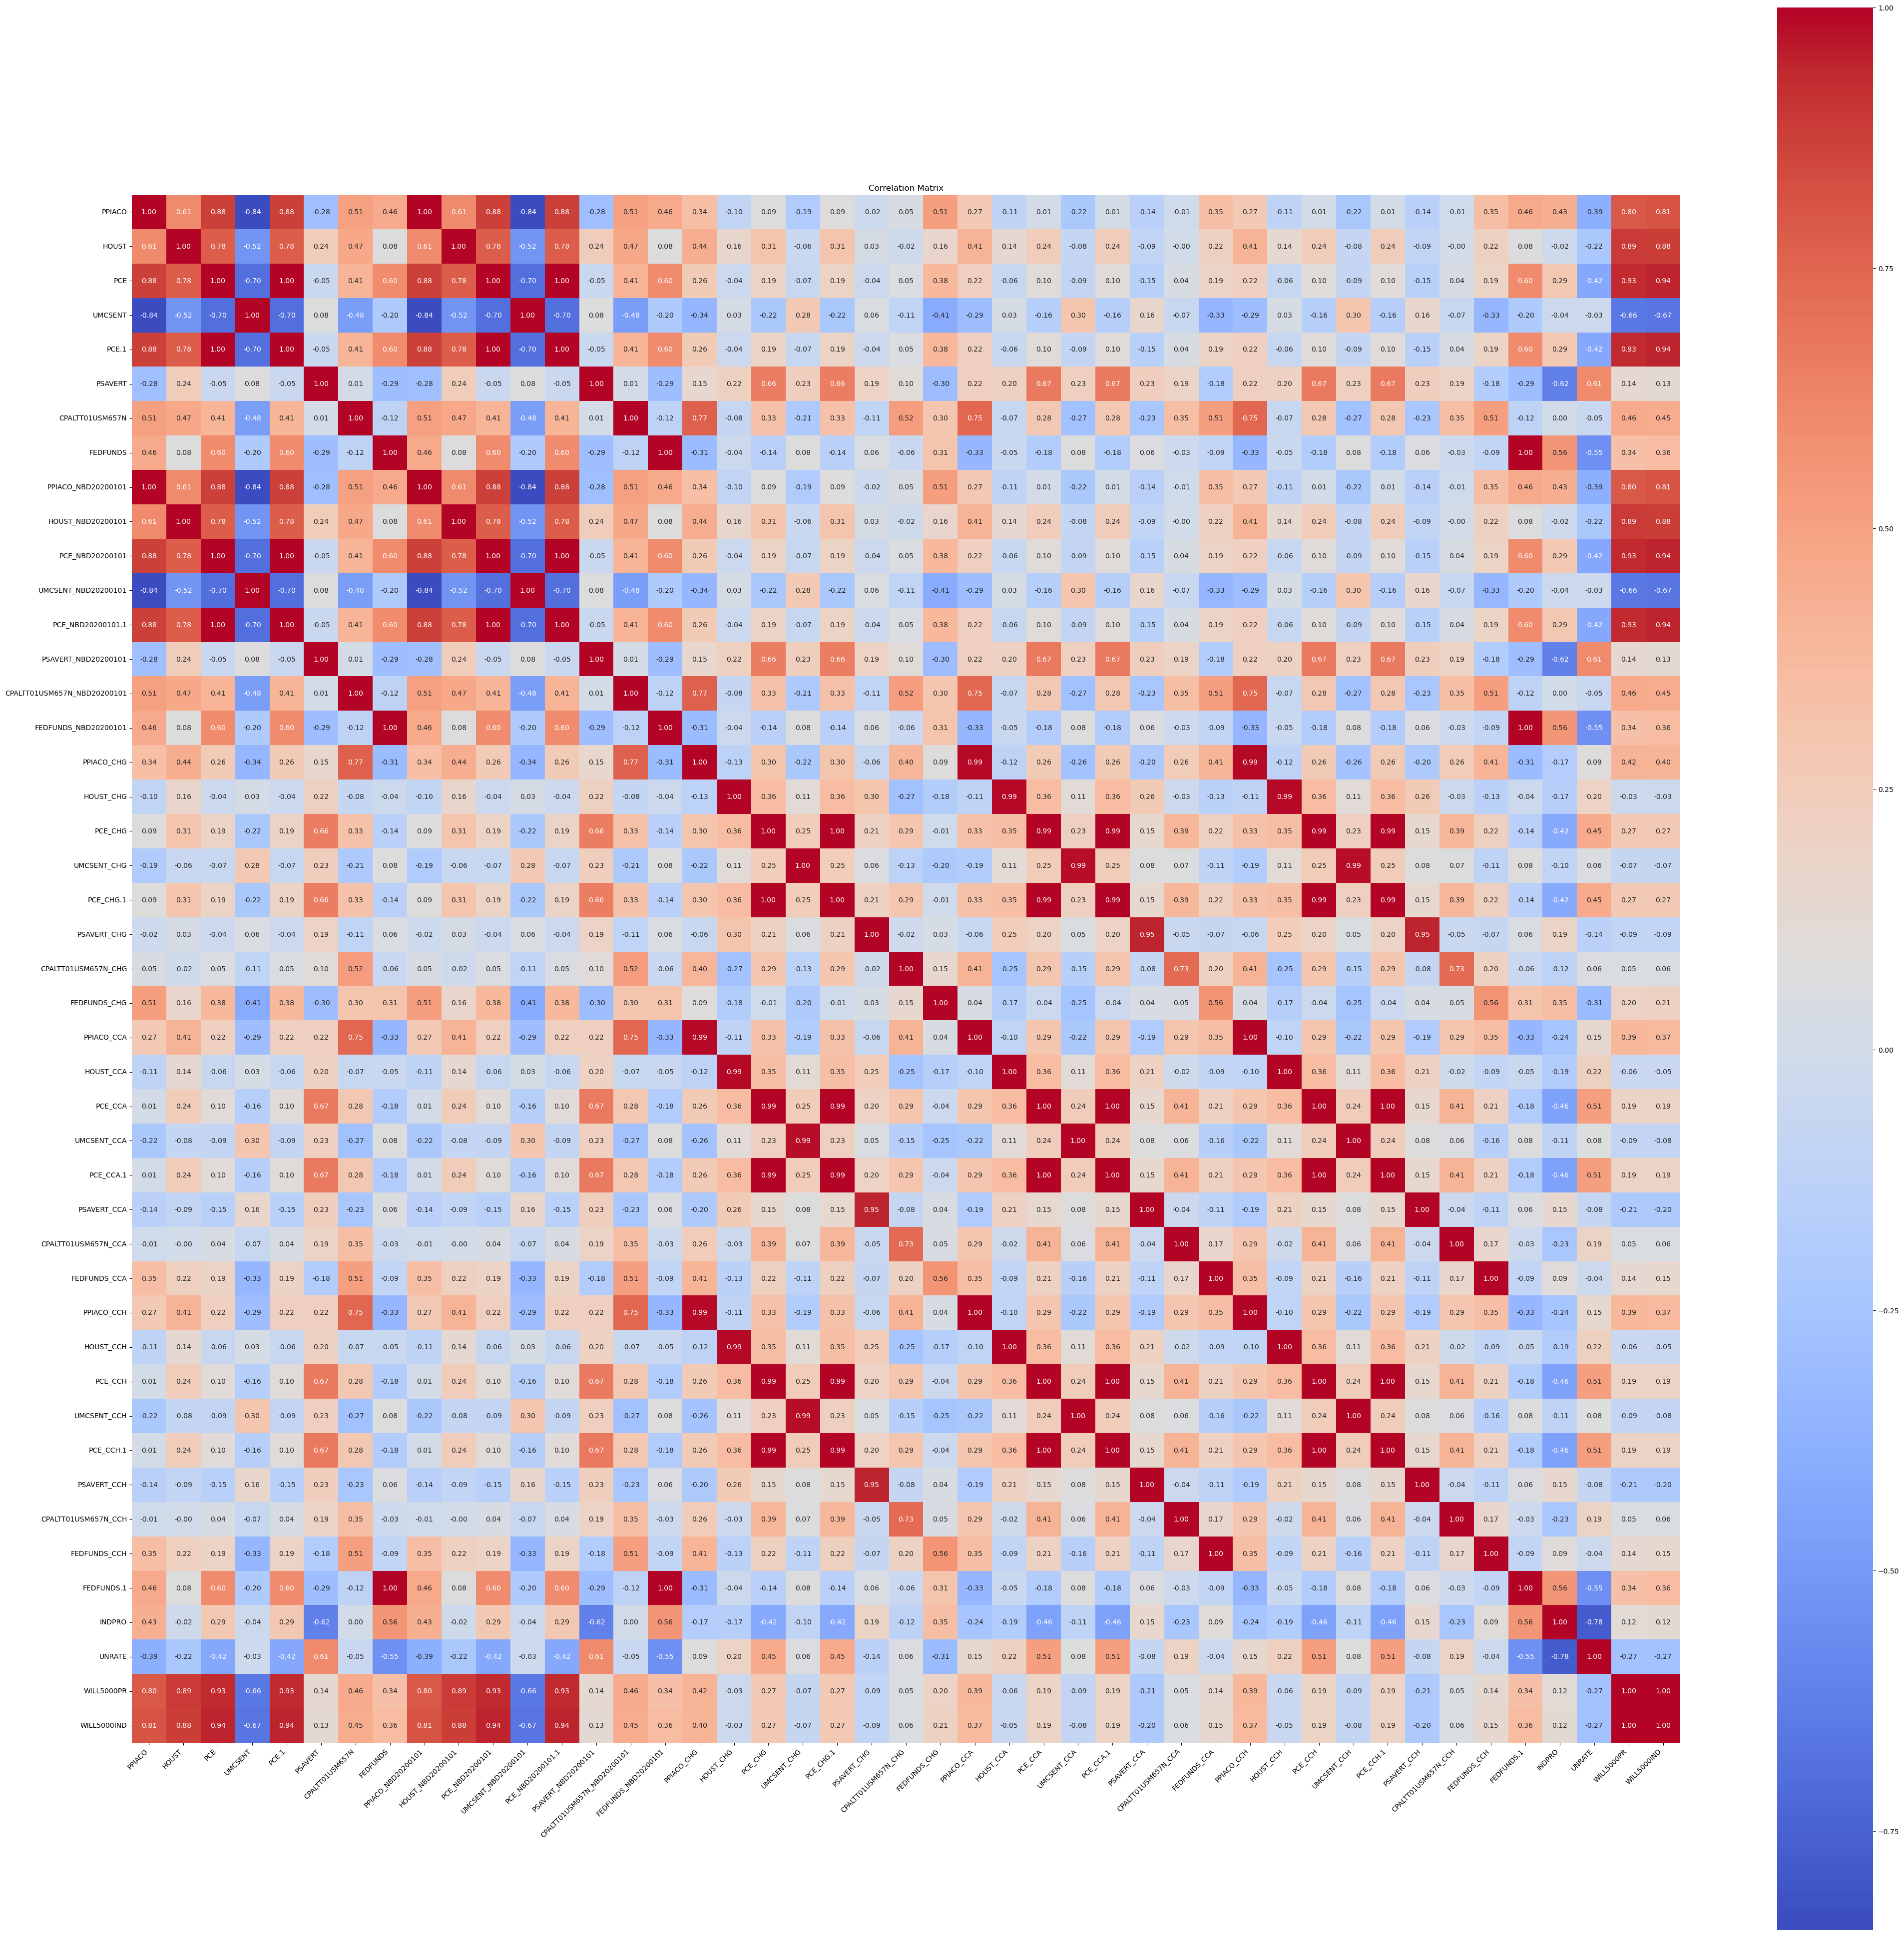

In [109]:
plot_corr_matrix(macro_test_no_date)

In [126]:
### Find highest correlating variables

def find_high_correlations(df, target_variable):
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Get correlations with the target variable, excluding the target itself
    correlations = correlation_matrix[target_variable].drop(target_variable)

    # Filter out perfect correlations of 1 or -1
    filtered_correlations = correlations[(correlations < 1) & (correlations > -1)]

    # Get the top 15 variables with the highest positive correlation (ignoring the sign)
    top_positive_correlations = filtered_correlations.abs().nlargest(20)
    print("Top 20 positive correlated variables with '", target_variable, "' (excluding perfect correlations):")
    print(top_positive_correlations)

    # Get the top 15 variables with the most negative correlation
    top_negative_correlations = filtered_correlations.nsmallest(20)
    print("Top 20 negative correlated variables with '", target_variable, "' (excluding perfect correlations):")
    print(top_negative_correlations)

    return top_positive_correlations, top_negative_correlations

top_vars = find_high_correlations(macro_test_no_date, "WILL5000PR")

## Feature engineering
- Make new features
- make lagging variables
- generate rolling statistics

In [ ]:
def create_new_features(df):
    # Example: Creating a new feature by multiplying two existing features
    columns_to_include = df.select_dtypes(include='number').drop(columns='DATE', errors='ignore').columns
    df['new_feature'] = df['existing_feature1'] * df['existing_feature2']
    # Add more feature engineering steps here as needed
    return df


def create_lagged_variables(df, columns=None, lag=1):
    if columns is None:
        columns = df.select_dtypes(include='number').drop(columns='DATE', errors='ignore').columns
    for col in columns:
        df[col] = df[col].shift(lag)
    return df

def generate_rolling_statistics(df, columns=None, window=5):
    if columns is None:
        columns = df.select_dtypes(include='number').drop(columns='DATE', errors='ignore').columns
    for col in columns:
        df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
    return df

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

def feature_engineering_with_sklearn(df):
    # 1. Principal Component Analysis (PCA)
    pca = PCA(n_components=3)  # Specify the number of principal components
    df_pca = pca.fit_transform(df.select_dtypes(include='number'))
    print("1")
    df_pca = pd.DataFrame(df_pca, columns=[f'PCA_{i+1}' for i in range(df_pca.shape[1])])
    print("2")
    # 2. Multidimensional Scaling (MDS)
    mds = MDS(n_components=2)  # Specify the number of dimensions
    df_mds = mds.fit_transform(df.select_dtypes(include='number'))
    print("3")
    df_mds = pd.DataFrame(df_mds, columns=['MDS_1', 'MDS_2'])
    print("4")

    return df_pca, df_mds


In [ ]:
test = macro_train_no_date
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PPIACO                       306 non-null    float64
 1   HOUST                        306 non-null    float64
 2   PCE                          306 non-null    float64
 3   UMCSENT                      306 non-null    float64
 4   PCE.1                        306 non-null    float64
 5   PSAVERT                      306 non-null    float64
 6   CPALTT01USM657N              306 non-null    float64
 7   FEDFUNDS                     306 non-null    float64
 8   PPIACO_NBD20200101           306 non-null    float64
 9   HOUST_NBD20200101            306 non-null    float64
 10  PCE_NBD20200101              306 non-null    float64
 11  UMCSENT_NBD20200101          306 non-null    float64
 12  PCE_NBD20200101.1            306 non-null    float64
 13  PSAVERT_NBD20200101 

In [ ]:
macro_train_no_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PPIACO                       306 non-null    float64
 1   HOUST                        306 non-null    float64
 2   PCE                          306 non-null    float64
 3   UMCSENT                      306 non-null    float64
 4   PCE.1                        306 non-null    float64
 5   PSAVERT                      306 non-null    float64
 6   CPALTT01USM657N              306 non-null    float64
 7   FEDFUNDS                     306 non-null    float64
 8   PPIACO_NBD20200101           306 non-null    float64
 9   HOUST_NBD20200101            306 non-null    float64
 10  PCE_NBD20200101              306 non-null    float64
 11  UMCSENT_NBD20200101          306 non-null    float64
 12  PCE_NBD20200101.1            306 non-null    float64
 13  PSAVERT_NBD20200101 

In [ ]:
macro_train_no_date.columns

Index(['PPIACO', 'HOUST', 'PCE', 'UMCSENT', 'PCE.1', 'PSAVERT',
       'CPALTT01USM657N', 'FEDFUNDS', 'PPIACO_NBD20200101',
       'HOUST_NBD20200101', 'PCE_NBD20200101', 'UMCSENT_NBD20200101',
       'PCE_NBD20200101.1', 'PSAVERT_NBD20200101',
       'CPALTT01USM657N_NBD20200101', 'FEDFUNDS_NBD20200101', 'PPIACO_CHG',
       'HOUST_CHG', 'PCE_CHG', 'UMCSENT_CHG', 'PCE_CHG.1', 'PSAVERT_CHG',
       'CPALTT01USM657N_CHG', 'FEDFUNDS_CHG', 'PPIACO_CCA', 'HOUST_CCA',
       'PCE_CCA', 'UMCSENT_CCA', 'PCE_CCA.1', 'PSAVERT_CCA',
       'CPALTT01USM657N_CCA', 'FEDFUNDS_CCA', 'PPIACO_CCH', 'HOUST_CCH',
       'PCE_CCH', 'UMCSENT_CCH', 'PCE_CCH.1', 'PSAVERT_CCH',
       'CPALTT01USM657N_CCH', 'FEDFUNDS_CCH', 'FEDFUNDS.1', 'INDPRO',
       'UNRATE'],
      dtype='object')

In [ ]:

df = macro_train_no_date

# Standardizing the data
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df)

# Applying PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_standardized)
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame for principal components with more descriptive naming
components_df = pd.DataFrame(pca.components_, columns=df.columns, index=['PC1', 'PC2'])
print("Principal Components Loadings:\n", components_df)

# Optionally, create a more interpretive description of each component based on loadings
def describe_component(component):
    strong_loadings = component[np.abs(component) > 0.4]  # Threshold to consider strong loading
    descriptions = [f"{('+' if val > 0 else '-')}{col}" for col, val in strong_loadings.items()]
    return " + ".join(descriptions)

component_descriptions = {f"PC{i + 1}": describe_component(components_df.loc[f"PC{i + 1}"]) for i in range(components_df.shape[0])}
print("\nDescriptive Labels for Principal Components:")
for pc, description in component_descriptions.items():
    print(f"{pc}: {description}")

Principal Components Loadings:
        PPIACO     HOUST       PCE   UMCSENT     PCE.1   PSAVERT  \
PC1  0.279126 -0.093207  0.289066  0.018245  0.289066 -0.249075   
PC2 -0.003683 -0.093565 -0.023258 -0.028654 -0.023258  0.081984   

     CPALTT01USM657N  FEDFUNDS  PPIACO_NBD20200101  HOUST_NBD20200101  ...  \
PC1        -0.102433 -0.256094            0.279126          -0.093207  ...   
PC2        -0.128057  0.013451           -0.003683          -0.093565  ...   

     HOUST_CCH   PCE_CCH  UMCSENT_CCH  PCE_CCH.1  PSAVERT_CCH  \
PC1  -0.000023 -0.101388    -0.015327  -0.101388     0.009243   
PC2  -0.015387 -0.309238     0.043558  -0.309238     0.221520   

     CPALTT01USM657N_CCH  FEDFUNDS_CCH  FEDFUNDS.1    INDPRO    UNRATE  
PC1             0.004910     -0.010996   -0.256094  0.278818 -0.031086  
PC2            -0.188394     -0.079536    0.013451 -0.043392  0.067862  

[2 rows x 43 columns]

Descriptive Labels for Principal Components:
PC1: 
PC2: 


In [ ]:
principal_components

array([[-4.87864623e+00, -3.97661833e+00],
       [-4.83652670e+00, -3.44266164e+00],
       [-4.67943509e+00, -2.55079249e+00],
       [-4.62728805e+00, -2.22174867e+00],
       [-4.53774170e+00, -1.89928615e+00],
       [-3.97801065e+00,  2.63954357e+00],
       [-4.65701534e+00, -1.53862011e+00],
       [-4.14737054e+00,  7.95671261e-02],
       [-4.62934301e+00, -1.56895220e+00],
       [-4.59700333e+00, -3.28189074e-01],
       [-4.50382340e+00, -1.46066262e+00],
       [-4.26197148e+00,  5.27220448e-01],
       [-4.76148041e+00, -1.88513314e+00],
       [-4.72298110e+00, -9.99363033e-01],
       [-4.40677144e+00, -4.08191573e-01],
       [-5.23566150e+00, -3.01875158e+00],
       [-4.84075778e+00, -1.81497663e+00],
       [-4.37927615e+00, -2.54542882e-01],
       [-5.40248326e+00, -3.83827442e+00],
       [-4.75942363e+00, -2.55080956e+00],
       [-4.52736723e+00,  5.73998511e-02],
       [-4.85023878e+00, -7.22937322e-01],
       [-4.75119782e+00,  5.16659054e-02],
       [-5.

In [ ]:
explained_variance_ratio

array([0.26687717, 0.16033694])

In [ ]:
components_df

PPIACO     HOUST       PCE   UMCSENT     PCE.1   PSAVERT  \
PC1  0.279126 -0.093207  0.289066  0.018245  0.289066 -0.249075   
PC2 -0.003683 -0.093565 -0.023258 -0.028654 -0.023258  0.081984   

     CPALTT01USM657N  FEDFUNDS  PPIACO_NBD20200101  HOUST_NBD20200101  ...  \
PC1        -0.102433 -0.256094            0.279126          -0.093207  ...   
PC2        -0.128057  0.013451           -0.003683          -0.093565  ...   

     HOUST_CCH   PCE_CCH  UMCSENT_CCH  PCE_CCH.1  PSAVERT_CCH  \
PC1  -0.000023 -0.101388    -0.015327  -0.101388     0.009243   
PC2  -0.015387 -0.309238     0.043558  -0.309238     0.221520   

     CPALTT01USM657N_CCH  FEDFUNDS_CCH  FEDFUNDS.1    INDPRO    UNRATE  
PC1             0.004910     -0.010996   -0.256094  0.278818 -0.031086  
PC2            -0.188394     -0.079536    0.013451 -0.043392  0.067862  

[2 rows x 43 columns]

## Lag the variables

In [ ]:

#https://github.com/feature-engine/feature_engine/blob/main/feature_engine/timeseries/forecasting/lag_features.py


def lag_the_features(df:pd.DataFrame, columns:int, periods, drop_na: bool): #needs to have the date column, periods need to be i.e. an int 1 or a list [1,2,3]
    df = pd.DataFrame(df)
    # df.set_index("DATE", inplace= True) #sort based on date

    lf = LagFeatures(variables = columns, periods = periods, fill_value=None, 
                 sort_index=True, missing_values='raise', 
                 drop_original=False, drop_na=False)
    
    # Apply transformation
    df_transformed = lf.fit_transform(df)

    # Display the transformed DataFrame with lag features
    return df_transformed

leading =["PPIACO", "HOUST", "PPIACO_NBD20200101", "HOUST_NBD20200101", "PPIACO_CHG", "HOUST_CHG", "PPIACO_CCA", "HOUST_CCA", "PPIACO_CCH", "HOUST_CCH"]

lagging_monthly = ["UNRATE", "UMCSENT", "UMCSENT_NBD20200101", "UMCSENT_CHG", "UMCSENT_CCA", "UMCSENT_CCH"]

coincident = ["PCE", "PCE.1", "PCE_NBD20200101", "PCE_NBD20200101.1", "PCE_CHG", "PCE_CHG.1",
  "PCE_CCA", "PCE_CCH", "PCE_CCH.1", "INDPRO", "CPALTT01USM657N", 
  "CPALTT01USM657N_NBD20200101", "CPALTT01USM657N_CHG", "CPALTT01USM657N_CCA",
    "CPALTT01USM657N_CCH", "PSAVERT", "PSAVERT_NBD20200101", "PSAVERT_CHG", 
    "PSAVERT_CCA", "PSAVERT_CCH", "FEDFUNDS", "FEDFUNDS_NBD20200101", 
    "FEDFUNDS_CHG", "FEDFUNDS_CCA", "FEDFUNDS_CCH", "FEDFUNDS.1"]


df_transformed_lagging_monthly =lag_the_features(macro_test_w_date, lagging_monthly, periods = [1,2,3], drop_na=False)
# df_transformed_lagging_monthly.to_csv("df_transformed_lagging_monthly.csv")


#returns something like below:
	# DATE	UNRATE	UNRATE_lag_1	UMCSENT_lag_1	UMCSENT_NBD20200101_lag_1	UMCSENT_CHG_lag_1	UMCSENT_CCA_lag_1	UMCSENT_CCH_lag_1	UNRATE_lag_2	UMCSENT_lag_2	UMCSENT_NBD20200101_lag_2	UMCSENT_CHG_lag_2	UMCSENT_CCA_lag_2	UMCSENT_CCH_lag_2	UNRATE_lag_3	UMCSENT_lag_3	UMCSENT_NBD20200101_lag_3	UMCSENT_CHG_lag_3	UMCSENT_CCA_lag_3	UMCSENT_CCH_lag_3
    # 306	7/1/2013	7.3																		
    # 307	8/1/2013	7.2	7.3	85.1	85.27054	1	14.18456	1.18205												
    # 308	9/1/2013	7.2	7.2	82.1	82.26453	-3	-43.06682	-3.5889	7.3	85.1	85.27054	1	14.18456	1.18205						
    # 309	2/1/2014	6.7	7.2	77.5	77.65531	-4.6	-69.1921	-5.76601	7.2	82.1	82.26453	-3	-43.06682	-3.5889	7.3	85.1	85.27054	1	14.18456	1.18205
    # 310	3/1/2014	6.7	6.7	81.6	81.76353	0.4	5.89682	0.4914	7.2	77.5	77.65531	-4.6	-69.1921	-5.76601	7.2	82.1	82.26453	-3	-43.06682	-3.5889
    # 311	4/1/2014	6.2	6.7	80	80.16032	-1.6	-23.76315	-1.98026	6.7	81.6	81.76353	0.4	5.89682	0.4914	7.2	77.5	77.65531	-4.6	-69.1921	-5.76601


## Check for stationarity

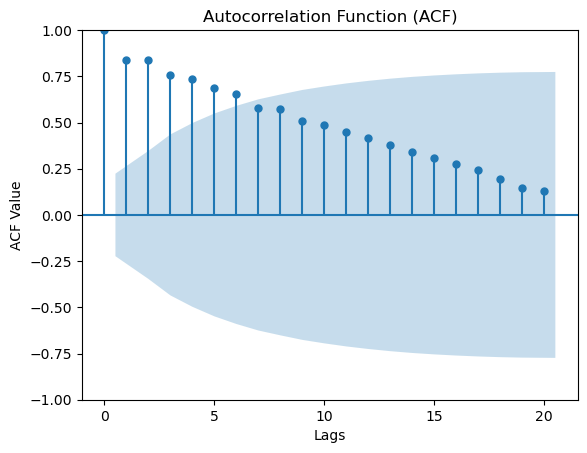

In [133]:
#https://medium.com/@JDEconomics/how-to-test-for-stationarity-in-time-series-data-using-python-44d82890aa9d
#Checking for Stationarity: Autocorrelation Function (ACF)
#to make it into the sub-graphs and add the values of ACF
plot_acf(macro_test_no_date["HOUST"], lags = 20)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lags")
plt.ylabel("ACF Value")
plt.show()

In [130]:
macro_test_no_date.columns

Index(['PPIACO', 'HOUST', 'PCE', 'UMCSENT', 'PCE.1', 'PSAVERT',
       'CPALTT01USM657N', 'FEDFUNDS', 'PPIACO_NBD20200101',
       'HOUST_NBD20200101', 'PCE_NBD20200101', 'UMCSENT_NBD20200101',
       'PCE_NBD20200101.1', 'PSAVERT_NBD20200101',
       'CPALTT01USM657N_NBD20200101', 'FEDFUNDS_NBD20200101', 'PPIACO_CHG',
       'HOUST_CHG', 'PCE_CHG', 'UMCSENT_CHG', 'PCE_CHG.1', 'PSAVERT_CHG',
       'CPALTT01USM657N_CHG', 'FEDFUNDS_CHG', 'PPIACO_CCA', 'HOUST_CCA',
       'PCE_CCA', 'UMCSENT_CCA', 'PCE_CCA.1', 'PSAVERT_CCA',
       'CPALTT01USM657N_CCA', 'FEDFUNDS_CCA', 'PPIACO_CCH', 'HOUST_CCH',
       'PCE_CCH', 'UMCSENT_CCH', 'PCE_CCH.1', 'PSAVERT_CCH',
       'CPALTT01USM657N_CCH', 'FEDFUNDS_CCH', 'FEDFUNDS.1', 'INDPRO', 'UNRATE',
       'WILL5000PR', 'WILL5000IND'],
      dtype='object')

In [139]:
# Augmented Dickey-Fuller Test for Stationarity
# Q if we have missing values in data-set, do we want to impute them with some value or put median/mean, or completely remove the rows
# mean imputation can affect us
# make a  looping function that will spit out the answer

adftest = adfuller(macro_test_no_date['HOUST'], autolag = "AIC", regression = "ct") #"ctt" for constant, linear and, quadratic trend
adftest
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")


ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.637802539071077
P-Value: 0.02679390346619939
Number of lags: 1
Number of observations: 109
Critical Values: {'1%': -4.044322283462378, '5%': -3.4515644781777084, '10%': -3.151118741781072}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [163]:
#apply logs, differences and multiply x100 the raw series
data = pd.DataFrame(data=macro_test_no_date['HOUST'])

# Apply logarithmic transformation
data['HOUST_logs'] = np.log(data['HOUST'])

# Calculate first differences
data["HOUST_diff"] = data['HOUST_logs'].diff()

# Convert to growth rates (multiply by 100)
data['HOUST_growth'] = data['HOUST_diff'] * 100

# Display the transformed dataset
data

HOUST  HOUST_logs  HOUST_diff  HOUST_growth
443   1085    6.989335         NaN           NaN
444    886    6.786717   -0.202618    -20.261832
445    960    6.866933    0.080216      8.021633
446   1190    7.081709    0.214775     21.477530
447   1079    6.983790   -0.097919     -9.791862
..     ...         ...         ...           ...
549   1512    7.321189    0.094253      9.425254
550   1566    7.356280    0.035091      3.509132
551   1375    7.226209   -0.130071    -13.007087
552   1549    7.345365    0.119156     11.915583
553   1321    7.186144   -0.159221    -15.922054

[111 rows x 4 columns]

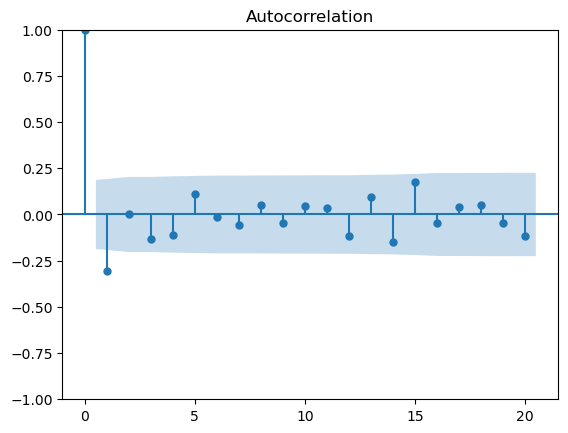

In [164]:
plot_acf(data['HOUST_growth'].dropna(), lags=20)
plt.show()

In [166]:
adftest = adfuller(data['HOUST_growth'].dropna(), autolag = 'AIC', regression = 'ct') #or c for regression
print("ADF Test Results")
print("Null Hypothesis: The series has an Unit Root")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary")

ADF Test Results
Null Hypothesis: The series has an Unit Root
ADF-Statistic: -8.165623548325394
P-Value: 1.373404438194477e-13
Number of lags: 3
Number of observations: 106
Critical Values {'1%': -2.5871552545389815, '5%': -1.9438072306333416, '10%': -1.6145345885529665}
Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary


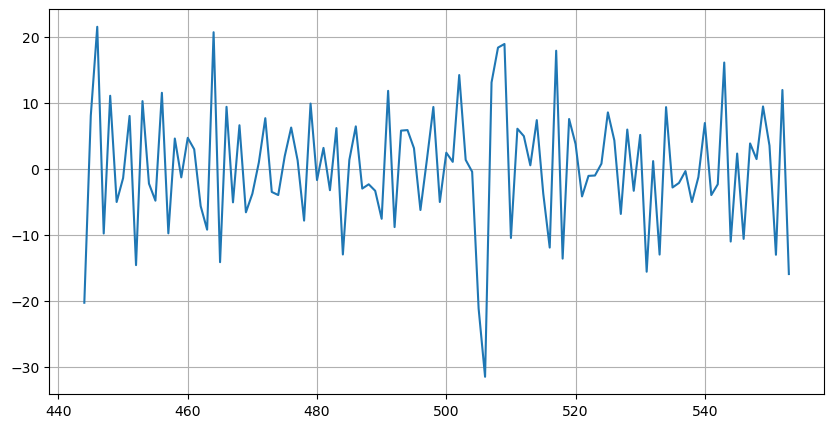

In [170]:
data['HOUST_growth'].plot(figsize = (10,5), grid = True) #data looks like this after applying  logs, differences and multiply x100 the raw series
                                                            # data is more stationary, has no trends and wiggles consistently around mean
plt.show()

In [178]:
def check_stationarity(series, maxlag=None, regression='ct', autolag='AIC'):
    result = adfuller(series, maxlag=maxlag, regression=regression, autolag=autolag)
    print('ADF Statistic: %f' % result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

<function __main__.check_stationarity(series, maxlag=None, regression='ct', autolag='AIC')>

ADF Statistic: -8.181582
p-value: 2.7185163068090217e-11
Critical Values:
	1%: -4.047
	5%: -3.453
	10%: -3.152
